# Italian to Greek
* In this Jupyter Notebook, we obtain the Italian to Greek translation by intentionally triggerring the 504 Gateway Timeout
* We disable retries and run it only once. 
* Logs will not be streamed, so that this notebook can be published on GitHub.

In [1]:
from scripts.translators import GPTClient
from scripts.data_management import EuroParlManager
from scripts.task import TranslationTask
from scripts.logger import TranslationLogger, logging_config
logging_config(logfile='it-el.log', stream=False) # logs only in .log file, not in stdout
logger = TranslationLogger(logfile='it-el.json')
dm = EuroParlManager()
cli = GPTClient(logger=logger)
cli.client.max_retries = 0 # disable auto-retry from GPTClient

task = TranslationTask(
    target_pairs=[('it', 'el')],
    dm=dm,
    client=cli,
    num_of_sents=400,
    max_retries=0,
    acceptable_range=(360, 480),
    logger=logger,
    mt_folder='tmp-it-el',
)

In [2]:
task.run()

In [3]:
!cat it-el.log | grep -P "INFO"

INFO: 2025-05-16 10:50:52 - [🏁]: Starting task 0994a62b-823a-4393-a0f2-433994a02452 on commit 70ae68d
INFO: 2025-05-16 10:55:53 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 504 Gateway Time-out"
INFO: 2025-05-16 10:55:53 - [⏭️]: Failed 0 times, skipping it-el...
INFO: 2025-05-16 10:55:53 - [🏁]: Task took 301.63s


* We then go to OpenAI's Platform and view the logs there:
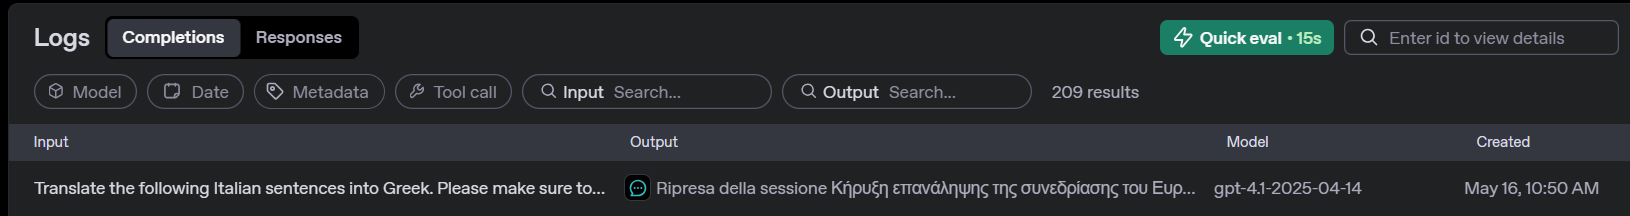

* Observe that the first sentence is still in Italian, this pattern was observed in other outputs as well.
* We can then access this response through code using the logged id.

In [1]:
from scripts.translators import GPTClient
cli = GPTClient()
response = cli.client.chat.completions.retrieve(
    "chatcmpl-BXl4IuCVnFZTSuF2Nwy7nMkqNRndr")
mt_text = response.choices[0].message.content
mt_lines = [ln.strip() for ln in mt_text.splitlines()]
len(mt_lines)

400

In [2]:
# Preserve response in .txt file
with open('it-el.txt', 'w') as f:
    for ln in mt_lines:
        print(ln, file=f)

* The log web page downloaded and preserved for transparancy purposes. If the OpenAI ever decides to discard the data, you can still verify the text by comparing it with the one that page.

### BLEU Check
* Check BLEU score directly without alignment

In [3]:
from scripts.data_management import EuroParlManager
from scripts.scoring import compute_bleu
dm = EuroParlManager()
src_sents, tgt_sents = dm.get_sentence_pairs('it', 'el', num_of_sents=400)
compute_bleu(ref=tgt_sents, hyp=mt_lines)

24.644441483296237